# An initial training pipeline

In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
import dask.dataframe as dd
import pandas as pd
import numpy as np

from glob import glob
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index().dropna()

c:\Users\jenni\miniconda3\envs\dsi_participant\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
cat_file = os.path.join(
    os.getenv("PRICE_CSV_DATA"), 
    'symbols_valid_meta.csv'
)
cat_df = (pd.read_csv(cat_file)
          .rename(columns = {'Symbol': 'ticker'})[['ticker', 'Listing Exchange', 'Market Category']] 
          # single bracket will say row,column, but double brackets will point at rows and then a list of columns
          # without that, we'll use row,column by default
          )
df = df.merge(cat_df, on = 'ticker', how = 'left') # doing left join just like in sql, df is left side, cat_df is the right side

## Preprocessing

+ Previously, we produced a features data set.
+ Most times, one or more [preprocessing steps](https://scikit-learn.org/stable/modules/preprocessing.html#) steps will be applied to data.
+ The most practical way to apply them is by arranging them in `Pipeline` objects, wchich are sequential transformations applied to data. 
+ It is convenient for us to label these transformations and there is a standard way of doing so.


## Transformations

+ Transformations are classes that implement `fit` and `transform` methods.

### StandardScaler

+ For example, transform a numerical variable by standardizing it.
- Standardization is removing the mean value of the feature and scale it by dividing non-constant features by their standard deviation.

$$
z = \frac{x-\mu}{\sigma}
$$


+  Using [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), one can do the following:

In [3]:
df.columns

Index(['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'source', 'Year', 'Close_lag_1', 'Listing Exchange', 'Market Category'],
      dtype='object')

In [4]:
df = (df.assign(
        returns = lambda x: x['Close']/x['Close_lag_1'] - 1, 
        positive_return = lambda x: 1.0*(x['returns'] > 0),
        hi_lo = lambda x: x['High'] - x['Low'],
        op_cl = lambda x: x['Close'] - x['Open']
    ).groupby(['ticker'], group_keys=False).apply(
        lambda x: x.assign(target = x['positive_return'].shift(-1))
    )
    .reset_index(drop=True)
    .dropna(subset = ['target'])
    )
df

C:\Users\jenni\AppData\Local\Temp\ipykernel_26612\619560177.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = (df.assign(


,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1,Listing Exchange,Market Category,returns,positive_return,hi_lo,op_cl,target
0,ABEV,2014-01-03,7.21,7.23,7.08,7.14,5.885602,6440000.0,ABEV.csv,2014,7.28,N,,-0.019231,0.0,0.15,-0.07,0.0
1,ABEV,2014-01-06,7.06,7.07,6.95,6.98,5.753713,6413200.0,ABEV.csv,2014,7.14,N,,-0.022409,0.0,0.12,-0.08,1.0
2,ABEV,2014-01-07,7.28,7.34,7.20,7.25,5.976277,19490500.0,ABEV.csv,2014,6.98,N,,0.038682,1.0,0.14,-0.03,0.0
3,ABEV,2014-01-08,7.24,7.32,7.21,7.25,5.976277,7226100.0,ABEV.csv,2014,7.25,N,,0.000000,0.0,0.11,0.01,0.0
4,ABEV,2014-01-09,7.22,7.23,7.06,7.08,5.836144,16323000.0,ABEV.csv,2014,7.25,N,,-0.023448,0.0,0.17,-0.14,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350165,ZIXI,2003-06-25,4.15,4.18,3.99,4.04,4.040000,112100.0,ZIXI.csv,2003,4.25,Q,Q,-0.049412,0.0,0.19,-0.11,0.0
350166,ZIXI,2003-06-26,4.04,4.19,3.86,4.00,4.000000,515300.0,ZIXI.csv,2003,4.04,Q,Q,-0.009901,0.0,0.33,-0.04,0.0
350167,ZIXI,2003-06-27,4.00,4.05,3.79,3.85,3.850000,162400.0,ZIXI.csv,2003,4.00,Q,Q,-0.037500,0.0,0.26,-0.15,0.0
350168,ZIXI,2003-06-30,3.84,4.00,3.72,3.77,3.770000,119900.0,ZIXI.csv,2003,3.85,Q,Q,-0.020779,0.0,0.28,-0.07,1.0


In [5]:
# Create a StandardScaler object

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()


# Fit the StandardScaler object with the returns data
std_scaler.fit(df['returns'].values.reshape(-1, 1))


StandardScaler()

In [6]:
# Transform the returns data using the fitted scaler

returns = df.returns.values.reshape(-1, 1)
scaled_returns_np = std_scaler.transform(df.returns.values.reshape(-1, 1))
scaled_returns = pd.DataFrame(scaled_returns_np, columns=['returns'])
scaled_returns.describe()

,returns
count,3.500830e+05
mean,-2.435569e-19
std,1.000001e+00
min,-5.083729e-02
25%,-2.627524e-03
50%,-2.145213e-03
75%,-1.662906e-03
max,5.806112e+02


###  OneHotEncoder

+ Categorical features can be encoded as numerical values using `OneHotEncoder`.

<Axes: xlabel='Listing Exchange'>

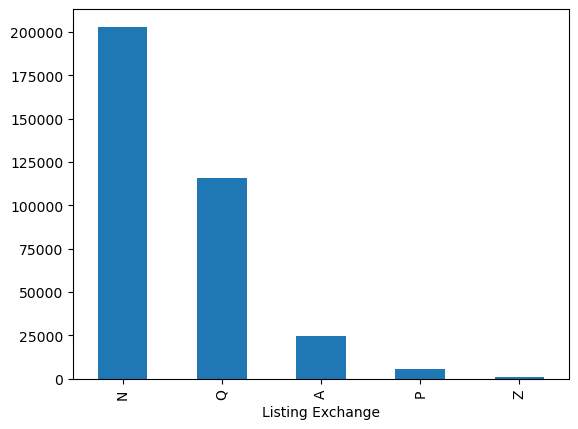

In [7]:
df['Listing Exchange'].value_counts().plot(kind = 'bar')

+ Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode a categorical variable as numerical.
+ Important parameters:

    - `categories` allows you to specify the categories to work with.
    - `drop`: we can drop the `'first'` value (dummy encoding) or `'if_binary'`, a convenience setting for binary values.
    - `handle_unknown` allows three options, `'error'`, `'ignore'`, and `'infrequent_if_exist'`, depending on what we want to do with new values.

In [8]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(df[['Listing Exchange']])

OneHotEncoder()

In [9]:
listing_enc = onehot.transform(df[['Listing Exchange']])
listing_enc.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

# Pipelines

+ It is impractical and costly to manipulate data "by hand". 
+ To manage data preprocessing steps within the cross-validation process use `Pipeline` objects.
+ A [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to sequentially apply transformation steps and, if required, a predictor.
+ `Pipeline` objects compose transforms, i.e., classes that implement `transform` and `fit` methods.
+ The purpose of `Pipeline` objects is to ensemble transforms and predictors to be used in cross-validation.
+ A `Pipeline` is defined by a list of tuples.
+ Each tuple is composed of `("name", <ColumnTransformer>)`, the name of the step and the `<ColumnTransformer>` function of our chosing.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


In [11]:
pipe1 = Pipeline(
    [
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('knn', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))

    ]
)
pipe1

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [12]:
X0 = df[['Listing Exchange', 'Market Category']]
Y0 = df['target']
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42)

pipe1.fit(X0_train, Y0_train)

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [13]:
Y_pred_train = pipe1.predict(X0_train)
Y_pred_test = pipe1.predict(X0_test)

In [14]:
Y_poba_train = pipe1.predict_proba(X0_train)
Y_proba_test = pipe1.predict_proba(X0_test)

In [15]:
res = {
    'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(Y0_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(Y0_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(Y0_test, Y_pred_test),
    'log_loss_train': log_loss(Y0_train, Y_poba_train),
    'log_loss_test': log_loss(Y0_test, Y_proba_test),
    'f1_score_train': f1_score(Y0_train, Y_pred_train),
    'f1_score_test': f1_score(Y0_test, Y_pred_test)
}
res

{'accuracy_score_train': 0.552983939499975,
 'accuracy_score_test': 0.5572503820500736,
 'cohen_kappa_train': np.float64(0.0),
 'cohen_kappa_test': np.float64(0.0),
 'log_loss_train': 0.68589340315988,
 'log_loss_test': 0.6851216166639613,
 'f1_score_train': 0.0,
 'f1_score_test': 0.0}

+ The model does not show great performance, but the pipeline shows results. 
+ Below, we expand the pipeline to include more variables, and further we will work with more robust model selection pipelines.

## ColumnTransformer

+ Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply transformers to specific columns of a DataFrame.
+ In this case, we will scale numeric variables and apply one-hot encoding to categorical columns.

In [16]:
from sklearn.compose import ColumnTransformer

In [17]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume', 'op_cl', 'hi_lo'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['Listing Exchange', 'Market Category']), 
    ], remainder='drop'
)

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)

# Model Selection

The model selection process is an iterative process in which :

+ Select schema and load data.
+ Define a pipeline and its (hyper) parameters.

    - Use ColumnTransformers to transform numeric and cateogrical variables.
    - Hyperparameters can be defined independently of code. 

+ Implement a splitting strategy. 

    - Use [cross_validate]() to select several metrics and operational details.

+ Measure performance.

    - [Select metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

+ Repeat

## Training, Validation, Testing Split

+ The first spliting strategy is to use a training, validation, and test set.
+ Training set will be used to fit the model.
+ Validation set is used to evaluate hyperparameter choice.
+ Testing set is used to evaluate performance on data the model has not yet seen.
+ In this case we want to compare two models: 

    - Decision Tree with 3 minumum samples per leaf.
    - Decision Tree with 10 minimum samples per leaf.

![](./images/03b_train_validate_test.png)

## Setting parameters in pipeline steps

+ One can obtain the parameters of a pipeline with `pipe.get_params()`.
+ We can set any parameter of a pipeline with `pipe.set_parames(**kwargs)`. 
+ The input `**kwargs` is a dictionary of the params to be modified. Params of the steps are labeled with the name of the step followed by `__` and the name of the parameter.

+ There are a few steps that we will repeat: 

    - Fit the candidate model on training data.
    - Predict on training and test data.
    - Compute training and test performance metrics.
    - Return.

+ We encapsulate this procedure in a function. 

In [18]:
def evaluate_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)
    Y_proba_train = clf.predict_proba(X_train)
    Y_proba_test = clf.predict_proba(X_test)
    performance_metrics = {
        'log_loss_train': log_loss(Y_train, Y_proba_train),
        'log_loss_test': log_loss(Y_test, Y_proba_test),
        'cohen_kappa_train': cohen_kappa_score(Y_train, Y_pred_train),
        'cohen_kappa_test': cohen_kappa_score(Y_test, Y_pred_test),
        'f1_score_train': f1_score(Y_train, Y_pred_train),
        'f1_score_test': f1_score(Y_test, Y_pred_test),
        'accuracy_score_train': accuracy_score(Y_train, Y_pred_train),
        'accuracy_score_test': accuracy_score(Y_test, Y_pred_test),
    }
    return performance_metrics

In [19]:
# Schema
X = df[['returns', 'op_cl', 'hi_lo', 'Volume', 'Listing Exchange', 'Market Category']]
Y = df['target']

# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)


In [20]:
# Evaluate hyperparameter configuration 2
pipe_d3 = pipe.set_params(**{'decisiontree__max_depth': 3})
res_d3 = evaluate_model(pipe_d3, X_train, Y_train, X_validate, Y_validate)
res_d3

{'log_loss_train': 0.6724984506674591,
 'log_loss_test': 0.6727458021172958,
 'cohen_kappa_train': np.float64(0.0),
 'cohen_kappa_test': np.float64(0.0),
 'f1_score_train': 0.0,
 'f1_score_test': 0.0,
 'accuracy_score_train': 0.553255494260261,
 'accuracy_score_test': 0.5518977398507516}

In [21]:
# Evaluate hyperparameter configuration 2
pipe_d15 = pipe.set_params(**{'decisiontree__max_depth':15})
res_d15 = evaluate_model(pipe_d15, X_train, Y_train, X_validate, Y_validate)
res_d15

{'log_loss_train': 0.6341818222028398,
 'log_loss_test': 1.3494436501566462,
 'cohen_kappa_train': np.float64(0.14386736765488006),
 'cohen_kappa_test': np.float64(0.07190645946057173),
 'f1_score_train': 0.4724595227647049,
 'f1_score_test': 0.4295414802534463,
 'accuracy_score_train': 0.5868503740203167,
 'accuracy_score_test': 0.5515585389366944}

## Cross-Validation

+ Cross-validation is a resampling method.
+ It is an iterative method applied to training data.
+ Training data is divided into folds.
+ Each fold is used once as a validation set and the rest of the folds are used for training.
+ Test data is used for final evaluation.

From [Scikit's Documentation ](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance), the diagram below shows the data divisions and folds during the cross-validation process.

![](./images/03b_grid_search_cross_validation.png)

There are two functions that can be used for [calculating cross-validation performance scores](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance): `cross_val_score()` and `cross_validate()`. The first function, [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), is a convenience function to get quick perfromance calculations. We will discuss `cross_validate()` as it offers advantages over `cross_val_score()`.

## Obtaining metrics

+ Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to measure one or more performance metrics and operational details.
+ There are two advantages of using this function. From [Scikit's documentation](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation):

>- It allows specifying multiple metrics for evaluation.
>- It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.


In [22]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipe_d3, X, Y, cv=5, scoring = scoring, return_train_score = True)

In DataFrame form:

In [23]:
pd.DataFrame(d3_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,2.521768,0.171992,0.550323,0.585084,0.368545,0.455081,0.493395,0.549555,0.294120,0.388324,0.560468,0.631858,-2.014829,-0.637670,-0.262459,-0.227242
1,2.492200,0.134148,0.494980,0.597984,0.284124,0.468843,0.386505,0.571043,0.224623,0.397671,0.465445,0.650157,-4.093470,-0.628486,-0.321971,-0.223281
2,2.362994,0.191864,0.500378,0.599577,0.500257,0.506597,0.451717,0.562589,0.560485,0.460742,0.496694,0.655390,-1.501543,-0.625187,-0.272758,-0.221891
3,2.204811,0.133102,0.541676,0.579201,0.416864,0.420031,0.482095,0.545394,0.367181,0.341528,0.557388,0.621957,-1.257588,-0.643292,-0.250057,-0.229188
4,2.443366,0.129884,0.549517,0.584507,0.365768,0.472306,0.491834,0.544939,0.291142,0.416758,0.557264,0.630670,-1.441524,-0.639068,-0.255677,-0.227570


In [24]:
d15_dict = cross_validate(pipe_d15, X, Y, cv=5, scoring = scoring, return_train_score = True)
pd.DataFrame(d15_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,2.500152,0.133322,0.550109,0.585098,0.368307,0.455141,0.492994,0.549569,0.293959,0.388404,0.560303,0.631885,-2.013804,-0.637678,-0.262463,-0.227243
1,2.328040,0.132925,0.498622,0.597980,0.277482,0.468820,0.388575,0.571043,0.215788,0.397639,0.469949,0.650152,-3.961405,-0.628504,-0.318376,-0.223286
2,3.751475,0.242360,0.500350,0.599673,0.500984,0.506983,0.451823,0.562646,0.562150,0.461342,0.496916,0.655534,-1.523827,-0.625140,-0.273083,-0.221868
3,2.428910,0.134263,0.541462,0.579201,0.416814,0.420060,0.481796,0.545388,0.367277,0.341568,0.556977,0.621961,-1.271179,-0.643271,-0.250330,-0.229182
4,3.679978,0.245695,0.549317,0.584457,0.365716,0.472099,0.491464,0.544894,0.291207,0.416462,0.556968,0.630582,-1.451267,-0.639094,-0.255777,-0.227588


# About Performance

+ Notice that in order to acquire information about our model and continue development, we are spending resources: time, electricity, equipment use, etc. As well, we are generating data and binary objects that implement our models (fitted `Pipeline` objects, for example).
+ For certain applications, operating performance (latency or `'score_time'`) may be as important or more important than predictive performance metrics. 
+ Every experiment throws important information and we can log them, as well as run them systematically.

In [25]:
pd.DataFrame(d15_dict).mean()

fit_time                 2.937711
score_time               0.177713
test_accuracy            0.527972
train_accuracy           0.589282
test_f1                  0.385860
train_f1                 0.464621
test_precision           0.461330
train_precision          0.554708
test_recall              0.346076
train_recall             0.401083
test_roc_auc             0.528222
train_roc_auc            0.638023
test_neg_log_loss       -2.044296
train_neg_log_loss      -0.634737
test_neg_brier_score    -0.272006
train_neg_brier_score   -0.225833
dtype: float64